# Install pkgs

**Note:** This is training notebook only. Inference ain't included in . 
Anybody who wants to use this notebook for inference purposes is most welcome.

In [ ]:
import os
import shutil
import numpy as np
from pathlib import Path
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.utils.checkpoint as checkpoint
from torch.utils.data import Dataset, DataLoader
import torchinfo
from torch.utils.tensorboard import SummaryWriter
import zarr, copick
from tqdm import tqdm
import napari
import mlflow
import mlflow.pytorch
from copick_utils.segmentation import segmentation_from_picks
import copick_utils.io.writers as write
from collections import defaultdict
import matplotlib.pyplot as plt
import pandas as pd
import gc
import concurrent.futures
import optuna, optunahub
from optuna.visualization import plot_slice, plot_param_importances
import json
import copy
import random
from sklearn.cluster import DBSCAN

gc.enable()

In [2]:
torch._dynamo.config.cache_size_limit = 64
torch.backends.cudnn.benchmark = True

In [3]:
notebook_number = '20250202_05'

In [4]:
path = '/media/max1024/Extreme SSD1/Kaggle/czii-cryo-et-object-identification/'
output_path = path + 'output/'

In [5]:
# Make a copick project

config_blob = """{
    "name": "czii_cryoet_mlchallenge_2024",
    "description": "2024 CZII CryoET ML Challenge training data.",
    "version": "1.0.0",

    "pickable_objects": [
        {
            "name": "apo-ferritin",
            "is_particle": true,
            "pdb_id": "4V1W",
            "label": 1,
            "color": [  0, 117, 220, 128],
            "radius": 60,
            "map_threshold": 0.0418
        },
        {
            "name": "beta-galactosidase",
            "is_particle": true,
            "pdb_id": "6X1Q",
            "label": 2,
            "color": [ 76,   0,  92, 128],
            "radius": 90,
            "map_threshold": 0.0578
        },
        {
            "name": "ribosome",
            "is_particle": true,
            "pdb_id": "6EK0",
            "label": 3,
            "color": [  0,  92,  49, 128],
            "radius": 150,
            "map_threshold": 0.0374
        },
        {
            "name": "thyroglobulin",
            "is_particle": true,
            "pdb_id": "6SCJ",
            "label": 4,
            "color": [ 43, 206,  72, 128],
            "radius": 130,
            "map_threshold": 0.0278
        },
        {
            "name": "virus-like-particle",
            "is_particle": true,
            "label": 5,
            "color": [255, 204, 153, 128],
            "radius": 135,
            "map_threshold": 0.201
        }
    ],

    "overlay_root": "/media/max1024/Extreme SSD1/Kaggle/czii-cryo-et-object-identification/output/overlay",

    "overlay_fs_args": {
        "auto_mkdir": true
    },

    "static_root": "/media/max1024/Extreme SSD1/Kaggle/czii-cryo-et-object-identification/train/static"
}"""

copick_config_path = path + "output/copick.config"
output_overlay = path + "output/overlay"

with open(copick_config_path, "w") as f:
    f.write(config_blob)
    
# Update the overlay
# Define source and destination directories
source_dir = path + 'train/overlay'
destination_dir = path + 'output/overlay'

# Walk through the source directory
def some_function():
    for root, dirs, files in os.walk(source_dir):
        # Create corresponding subdirectories in the destination
        relative_path = os.path.relpath(root, source_dir)
        target_dir = os.path.join(destination_dir, relative_path)
        os.makedirs(target_dir, exist_ok=True)
        
        # Copy and rename each file
        for file in files:
            if file.startswith("curation_0_"):
                new_filename = file
            else:
                new_filename = f"curation_0_{file}"
                
            
            # Define full paths for the source and destination files
            source_file = os.path.join(root, file)
            destination_file = os.path.join(target_dir, new_filename)
            
            # Copy the file with the new name
            shutil.copy2(source_file, destination_file)
            print(f"Copied {source_file} to {destination_file}")

some_function()

Copied /media/max1024/Extreme SSD1/Kaggle/czii-cryo-et-object-identification/train/overlay/ExperimentRuns/TS_5_4/Picks/apo-ferritin.json to /media/max1024/Extreme SSD1/Kaggle/czii-cryo-et-object-identification/output/overlay/ExperimentRuns/TS_5_4/Picks/curation_0_apo-ferritin.json
Copied /media/max1024/Extreme SSD1/Kaggle/czii-cryo-et-object-identification/train/overlay/ExperimentRuns/TS_5_4/Picks/beta-amylase.json to /media/max1024/Extreme SSD1/Kaggle/czii-cryo-et-object-identification/output/overlay/ExperimentRuns/TS_5_4/Picks/curation_0_beta-amylase.json
Copied /media/max1024/Extreme SSD1/Kaggle/czii-cryo-et-object-identification/train/overlay/ExperimentRuns/TS_5_4/Picks/beta-galactosidase.json to /media/max1024/Extreme SSD1/Kaggle/czii-cryo-et-object-identification/output/overlay/ExperimentRuns/TS_5_4/Picks/curation_0_beta-galactosidase.json
Copied /media/max1024/Extreme SSD1/Kaggle/czii-cryo-et-object-identification/train/overlay/ExperimentRuns/TS_5_4/Picks/ribosome.json to /media

# Prepare the dataset

In [6]:
root = copick.from_file(copick_config_path)

copick_user_name = "copickUtils"
copick_segmentation_name = "paintedPicks"
voxel_size = 10
#tomo_type = "denoised"

## 2. Generate multi-class segmentation masks from picks, and saved them to the copick overlay directory (one-time)

In [7]:
root

CopickRoot(user_id=None, len(pickable_objects)=None, len(runs)=None) at 0x74cda03737a0

In [8]:
def generate_masks_function():
    target_objects = defaultdict(dict)
    for object in root.pickable_objects:
        if object.is_particle:
            target_objects[object.name]['label'] = object.label
            target_objects[object.name]['radius'] = object.radius


    for run in tqdm(root.runs):
        tomo = run.get_voxel_spacing(voxel_size)
        for tomogram in tomo.tomograms:
            tomo_type = tomogram.tomo_type
            if tomo_type != 'denoised':
                continue
            image = tomogram.numpy()
            target = np.zeros(image.shape, dtype=np.uint8)
            for pickable_object in root.pickable_objects:
                pick = run.get_picks(object_name=pickable_object.name, user_id='curation')
                if len(pick):
                    target = segmentation_from_picks.from_picks(pick[0],
                                                                target,
                                                                target_objects[pickable_object.name]['radius'],
                                                                target_objects[pickable_object.name]['label']
                                                               )
            write.segmentation(run, target, copick_user_name, name=copick_segmentation_name)

In [9]:
# Just do this once
generate_masks = True

if generate_masks:
    generate_masks_function()

100%|█████████████████████████████████████████████| 7/7 [00:04<00:00,  1.59it/s]


In [10]:
train_label_experiment_folders_path = '/media/max1024/Extreme SSD1/Kaggle/czii-cryo-et-object-identification/' + 'train/overlay/ExperimentRuns/'

In [11]:
class_ids = {
    'apo-ferritin': 1,
    'beta-galactosidase': 2,
    'ribosome': 3,
    'thyroglobulin': 4,
    'virus-like-particle': 5,
}

In [12]:
particle_radius = {
    'apo-ferritin': 60,
    'beta-galactosidase': 90,
    'ribosome': 150,
    'thyroglobulin': 130,
    'virus-like-particle': 135,
}

In [13]:
def create_labels_df(experiment):
    labels_dict = {}
    
    particle_types_dict = {}
    
    with open(f'{train_label_experiment_folders_path}{experiment}/Picks/apo-ferritin.json') as f:
        loaded_json = json.loads(f.read())
    particle_types_dict['apo-ferritin'] = loaded_json
    
    with open(f'{train_label_experiment_folders_path}{experiment}/Picks/beta-galactosidase.json') as f:
        loaded_json = json.loads(f.read())
    particle_types_dict['beta-galactosidase'] = loaded_json
    
    with open(f'{train_label_experiment_folders_path}{experiment}/Picks/ribosome.json') as f:
        loaded_json = json.loads(f.read())
    particle_types_dict['ribosome'] = loaded_json
    
    with open(f'{train_label_experiment_folders_path}{experiment}/Picks/thyroglobulin.json') as f:
        loaded_json = json.loads(f.read())
    particle_types_dict['thyroglobulin'] = loaded_json
    
    with open(f'{train_label_experiment_folders_path}{experiment}/Picks/virus-like-particle.json') as f:
        loaded_json = json.loads(f.read())
    particle_types_dict['virus-like-particle'] = loaded_json
    
    labels_dict[experiment] = particle_types_dict

    experiment_list = []
    particle_type_list = []
    x_list = []
    y_list = []
    z_list = []
    r_list = []
    class_id_list = []
    #print(experiment)
    #print(len(labels_dict[experiment]['apo-ferritin']['points']))
    #print(type(labels_dict[experiment]['apo-ferritin']['points']))
    #print(labels_dict[experiment]['apo-ferritin']['points'][0])

    for key in labels_dict[experiment].keys():
        #print(labels_dict[experiment][key])
        #print(labels_dict[experiment][key]['pickable_object_name'])
        for i in range(len(labels_dict[experiment][key]['points'])):
            experiment_list.append(labels_dict[experiment][key]['run_name'])
            particle_type_list.append(labels_dict[experiment][key]['pickable_object_name'])
            x_list.append(labels_dict[experiment][key]['points'][i]['location']['x']/10.012444537618887)
            y_list.append(labels_dict[experiment][key]['points'][i]['location']['y']/10.012444196428572)
            z_list.append(labels_dict[experiment][key]['points'][i]['location']['z']/10.012444196428572)
            r_list.append(particle_radius[key]/10)
            class_id_list.append(class_ids[key])

    labels_df = pd.DataFrame({'experiment':experiment_list, 'particle_type':particle_type_list, 'x':x_list, 'y':y_list, 'z':z_list, 'radius':r_list, 'label':class_id_list})
    
    return labels_df

In [14]:
# Define enzyme radii
particle_radius = {
    'apo-ferritin': 60 / 10,
    'beta-galactosidase': 90 / 10,
    'ribosome': 150 / 10,
    'thyroglobulin': 130 / 10,
    'virus-like-particle': 135 / 10,
}

# Map enzyme names to numerical class labels (for segmentation)
enzyme_class_mapping = {
    'apo-ferritin': 1,
    'beta-galactosidase': 2,
    'ribosome': 3,
    'thyroglobulin': 4,
    'virus-like-particle': 5,
}

In [15]:
def create_gaussian_heatmaps(image_shape, locations_df, sigma_scale=1):
    """
    Creates a 5-channel Gaussian heatmap volume (one channel per enzyme class).
    Each channel contains Gaussian blobs centered at enzyme locations of that class.
    
    Args:
        image_shape: (z, y, x) tuple - shape of 3D volume
        locations_df: DataFrame with columns ['z', 'y', 'x', 'particle_type']
        sigma_scale: Ratio of sigma to enzyme radius (controls Gaussian spread)
    
    Returns:
        heatmaps: np.ndarray with shape (5, z, y, x)
    """
    num_classes = 5
    heatmaps = np.zeros((num_classes,) + image_shape, dtype=np.float32)

    centers = locations_df[['z', 'y', 'x']].values
    enzyme_names = locations_df['particle_type'].values

    for center, enzyme_name in zip(centers, enzyme_names):
        if enzyme_name not in particle_radius:
            continue

        # Get enzyme properties
        radius = particle_radius[enzyme_name]
        class_label = enzyme_class_mapping[enzyme_name]  # Should map to 1-5
        channel_idx = class_label - 1  # Convert to 0-based index

        # Calculate Gaussian parameters
        sigma = radius * sigma_scale
        truncate = 3  # Number of sigmas to consider for bounding box

        # Bounding box calculations (3σ truncation)
        z_min = max(0, int(center[0] - sigma * truncate))
        z_max = min(image_shape[0], int(center[0] + sigma * truncate) + 1)
        y_min = max(0, int(center[1] - sigma * truncate))
        y_max = min(image_shape[1], int(center[1] + sigma * truncate) + 1)
        x_min = max(0, int(center[2] - sigma * truncate))
        x_max = min(image_shape[2], int(center[2] + sigma * truncate) + 1)

        if z_min >= z_max or y_min >= y_max or x_min >= x_max:
            continue

        # Create local grid
        zz, yy, xx = np.meshgrid(
            np.arange(z_min, z_max),
            np.arange(y_min, y_max),
            np.arange(x_min, x_max),
            indexing='ij'
        )

        # Compute squared distance from center
        dx = xx - center[2]  # x-coordinate difference
        dy = yy - center[1]  # y-coordinate difference
        dz = zz - center[0]  # z-coordinate difference
        dist_sq = dx**2 + dy**2 + dz**2

        # Compute Gaussian values
        gaussian = np.exp(-dist_sq / (2 * sigma**2))
        
        # Add to the corresponding channel (using np.maximum to handle overlaps)
        heatmaps[channel_idx, z_min:z_max, y_min:y_max, x_min:x_max] = np.maximum(
            heatmaps[channel_idx, z_min:z_max, y_min:y_max, x_min:x_max],
            gaussian
        )

    return heatmaps

In [16]:
def create_data():
    images_list = []
    heatmaps_list = []
    segmentations_list = []
    label_dfs_list = []
    
    for run in tqdm(root.runs):
        tomo = run.get_voxel_spacing(voxel_size)#.get_tomograms(tomo_type)[0].numpy()
        labels_df = create_labels_df(run.name)
        for tomogram in tomo.tomograms:
            tomo_type = tomogram.tomo_type
            if tomo_type != 'denoised':
                continue
            image = tomogram.numpy()
            segmentation = run.get_segmentations(name=copick_segmentation_name, user_id=copick_user_name, voxel_size=voxel_size, is_multilabel=True)[0].numpy()
            segmentations_list.append(segmentation)
            images_list.append(image)

            heatmap = create_gaussian_heatmaps(image.shape, labels_df)
            heatmaps_list.append(heatmap)
            
            label_dfs_list.append(labels_df)

    images_array = np.array(images_list)
    segmentations_array = np.array(segmentations_list)
    heatmaps_array = np.array(heatmaps_list)

    images_array = np.expand_dims(images_array, axis=1)
    segmentations_array = np.expand_dims(segmentations_array, axis=1)

    return images_array, heatmaps_array, segmentations_array, label_dfs_list

In [17]:
images_array, heatmaps_array, segmentations_array, label_dfs_list = create_data()

100%|█████████████████████████████████████████████| 7/7 [00:10<00:00,  1.49s/it]


In [18]:
images_array.shape

(7, 1, 184, 630, 630)

In [19]:
heatmaps_array.shape

(7, 5, 184, 630, 630)

In [20]:
segmentations_array.shape

(7, 1, 184, 630, 630)

In [21]:
label_dfs_list[0]

,experiment,particle_type,x,y,z,radius,label
0,TS_5_4,apo-ferritin,46.793168,590.855328,60.341610,0.60,1
1,TS_5_4,apo-ferritin,566.764088,111.296900,56.436569,0.60,1
2,TS_5_4,apo-ferritin,573.736911,104.786801,65.289952,0.60,1
3,TS_5_4,apo-ferritin,587.345975,112.394934,57.883968,0.60,1
4,TS_5_4,apo-ferritin,465.587298,126.791918,80.940176,0.60,1
...,...,...,...,...,...,...,...
125,TS_5_4,virus-like-particle,263.326203,420.974132,96.421012,1.35,5
126,TS_5_4,virus-like-particle,313.349651,356.801989,37.245052,1.35,5
127,TS_5_4,virus-like-particle,329.003870,302.370125,67.323222,1.35,5
128,TS_5_4,virus-like-particle,299.396016,494.206799,116.792162,1.35,5


In [22]:
exp_names_list = []
for i in range(len(label_dfs_list)):
    exp_name = label_dfs_list[i]['experiment'][0]
    exp_names_list.append(exp_name)
exp_names_sr = pd.Series(exp_names_list)
unique_exp_names = exp_names_sr.unique()
unique_exp_names

array(['TS_5_4', 'TS_69_2', 'TS_6_4', 'TS_6_6', 'TS_73_6', 'TS_86_3',
       'TS_99_9'], dtype=object)

# Visualize the tomogram and gaussian heatmaps

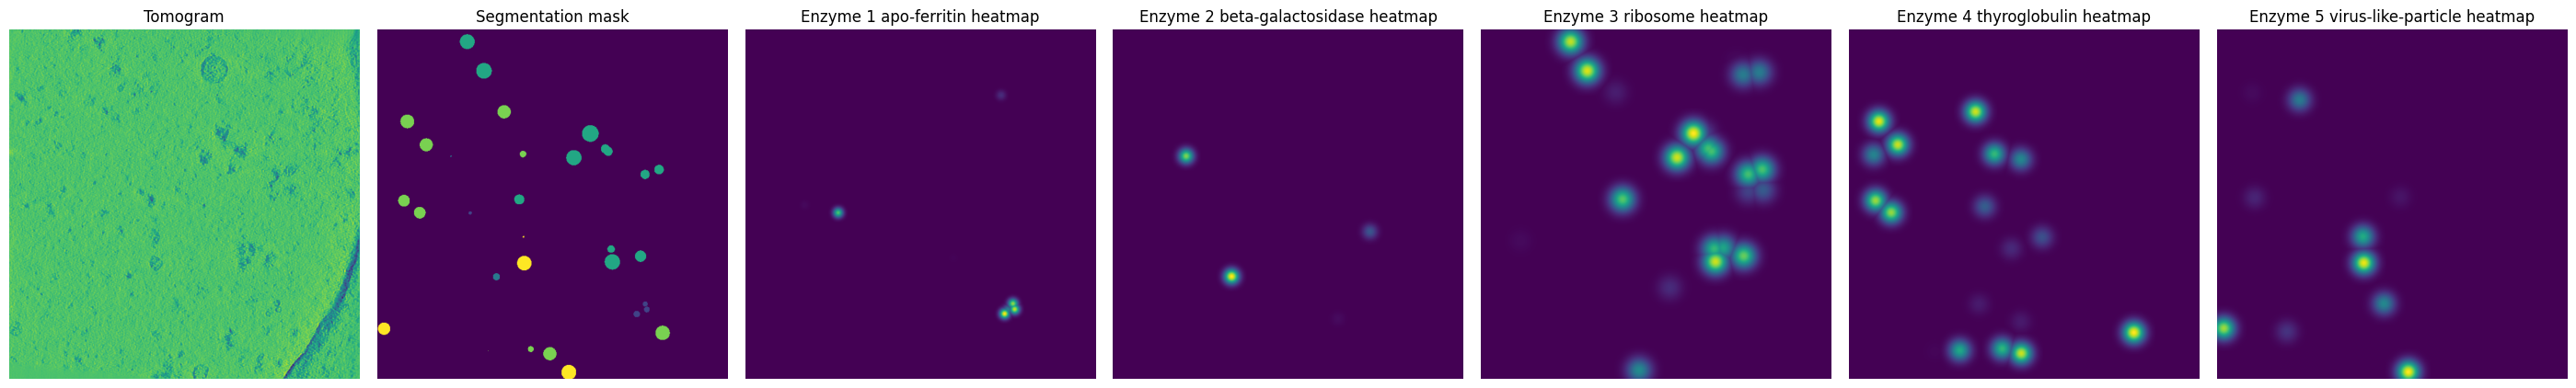

In [23]:
# Create figure
fig, axes = plt.subplots(1, 7, figsize=(28, 4))  # Adjust figsize to control spacing

# Image 1
axes[0].imshow(images_array[0][0][100])
axes[0].set_title('Tomogram')
axes[0].axis('off')

# Image 2
axes[1].imshow(segmentations_array[0][0][100])
axes[1].set_title('Segmentation mask')
axes[1].axis('off')

# Image 3
axes[2].imshow(heatmaps_array[0][0][100])
axes[2].set_title('Enzyme 1 apo-ferritin heatmap')
axes[2].axis('off')

# Image 4
axes[3].imshow(heatmaps_array[0][1][100])
axes[3].set_title('Enzyme 2 beta-galactosidase heatmap')
axes[3].axis('off')

# Image 5
axes[4].imshow(heatmaps_array[0][2][100])
axes[4].set_title('Enzyme 3 ribosome heatmap')
axes[4].axis('off')

# Image 6
axes[5].imshow(heatmaps_array[0][3][100])
axes[5].set_title('Enzyme 4 thyroglobulin heatmap')
axes[5].axis('off')

# Image 7
axes[6].imshow(heatmaps_array[0][4][100])
axes[6].set_title('Enzyme 5 virus-like-particle heatmap')
axes[6].axis('off')

# Reduce spacing
plt.subplots_adjust(wspace=0.05)  # Reduce horizontal space between images
plt.tight_layout(pad=0.1, w_pad=0.1, h_pad=0.1)  # Further minimize padding

plt.show()

# Simulated data prep

In [24]:
simulated_data_path = '../../czii_downloaded_data/simulated_training_data/'

In [25]:
simulated_experiments_list = [f for f in os.listdir(simulated_data_path) if 'TS_' in f]
simulated_experiments_list

FileNotFoundError: [Errno 2] No such file or directory: '../../czii_downloaded_data/simulated_training_data/'

In [26]:
particle_info = {
    "apo-ferritin": {"label": 1, "radius": 60},
    "beta-galactosidase": {"label": 2, "radius": 90},
    "ribosome": {"label": 3, "radius": 150},
    "thyroglobulin": {"label": 4, "radius": 130},
    "virus-like-particle": {"label": 5, "radius": 135}
}

In [27]:
particle_name_dict = {
    'ferritin':'apo-ferritin',
    'galacto':'beta-galactosidase',
    'ribosome':'ribosome',
    'thyro':'thyroglobulin',
    'vlp':'virus-like-particle'
}

In [28]:
def process_experiment(experiment):
    """Process a single experiment in parallel"""
    # Load tomogram data
    tomogram_path = f'{simulated_data_path}{experiment}/Reconstructions/VoxelSpacing10.000/Tomograms/100/{experiment}.zarr'
    tomogram = zarr.open(tomogram_path, mode='r')[0].__array__()
    
    location_dfs_list = []
    annotations_base = f'{simulated_data_path}{experiment}/Reconstructions/VoxelSpacing10.000/Annotations/'
    
    # Process location files
    for location_folder in os.listdir(annotations_base):
        location_dir = os.path.join(annotations_base, location_folder)
        for location_file in os.listdir(location_dir):
            if 'orientedpoint.ndjson' not in location_file:
                continue
                
            # Determine particle type
            particle_type = None
            for key in particle_name_dict.keys():
                if key in location_file:
                    particle_type = particle_name_dict[key]
                    break
            if not particle_type:
                continue
                
            # Process NDJSON file
            label = particle_info[particle_type]['label']
            radius = particle_info[particle_type]['radius']
            file_path = os.path.join(location_dir, location_file)
            
            location_df = pd.read_json(file_path, lines=True)
            location_df['x'] = location_df['location'].map(lambda x: x['x'])
            location_df['y'] = location_df['location'].map(lambda x: x['y'])
            location_df['z'] = location_df['location'].map(lambda x: x['z'])
            location_df['label'] = label
            location_df['radius'] = radius / 10.012444
            location_df['particle_type'] = particle_type
            
            location_dfs_list.append(location_df)
    
    # Create mask and return result
    if location_dfs_list:
        all_particle_locations_df = pd.concat(location_dfs_list, ignore_index=True)
        mask_image = create_gaussian_heatmaps(tomogram.shape, all_particle_locations_df)
        all_particle_locations_df['experiment'] = experiment
        label_df = all_particle_locations_df[['experiment', 'particle_type', 'x', 'y', 'z', 'radius', 'label']]
        return {"tomo_type": 'Unknown', "image": tomogram, "label": mask_image, "label_df": label_df}
    return None

def append_simulation_data():
    global data_dicts
    max_workers = os.cpu_count() // 2  # Use half the available cores to prevent memory issues
    
    with concurrent.futures.ProcessPoolExecutor(max_workers=max_workers) as executor:
        # Submit all experiments for processing
        futures = [executor.submit(process_experiment, exp) for exp in simulated_experiments_list]
        
        # Collect results as they complete
        for future in tqdm(concurrent.futures.as_completed(futures), 
                         total=len(simulated_experiments_list),
                         desc="Processing experiments"):
            result = future.result()
            if result:
                data_dicts.append(result)

In [29]:
#append_simulation_data()

# Prepare dataloaders

In [30]:
from monai.transforms import Compose, EnsureChannelFirst, NormalizeIntensity, Orientation, RandGaussianNoise, RandRotate90, RandFlip, RandSpatialCrop, RandAdjustContrast, RandCropByLabelClasses

num_classes = 5
my_num_samples = 16
loader_workers = 8
cube_size = 160
batch_size = 1

# Non-random transforms to be cached
non_random_transforms = Compose([
    EnsureChannelFirst(channel_dim=0),
    Orientation(axcodes="RAS"),
])

images_only_transforms = Compose([
    NormalizeIntensity(),
    #RandGaussianNoise(prob=0.2, std=0.01),
    #RandAdjustContrast(prob=0.5, gamma=(0.7, 1.3)),  # Random contrast change
])

random_transforms = Compose([
    RandRotate90(prob=0.5, spatial_axes=(1, 2)),
    RandFlip(prob=0.5, spatial_axis=0),
    RandSpatialCrop(roi_size=(cube_size, cube_size, cube_size), random_center=True),
])

val_images_only_transforms = Compose([
    NormalizeIntensity(),
])

class EnzymeDataset(Dataset):
    def __init__(self, images, heatmaps, non_random_transform=None, image_only_transform=None, transform=None):
        """
        Args:
            images: np.ndarray/tensor of shape (num_samples, 1, D, H, W)
            heatmaps: np.ndarray/tensor of shape (num_samples, 5, D, H, W)
            transform: Callable transform to apply to both image and heatmap
        """
        self.images = torch.as_tensor(images, dtype=torch.float32)
        self.heatmaps = torch.as_tensor(heatmaps, dtype=torch.float32)
        self.non_random_transform = non_random_transform
        self.image_only_transform = image_only_transform
        self.transform = transform

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        image = self.images[idx]  # Shape: (1, D, H, W)
        heatmap = self.heatmaps[idx]  # Shape: (5, D, H, W)

        if self.non_random_transform:
            combined = torch.cat([image, heatmap], dim=0)
            combined = self.non_random_transform(combined)
            image = combined[0:1]
            heatmap = combined[1:]

        if self.image_only_transform:
            image = self.image_only_transform(image)
            

        if self.transform:
            # Apply the same spatial transform to both image and heatmap
            # Concatenate to process together (channel dimension becomes 1+5=6)
            combined = torch.cat([image, heatmap], dim=0)  # (6, D, H, W)
            combined = self.transform(combined)
            
            # Split back into image and heatmap
            image = combined[0:1]  # (1, D, H, W)
            heatmap = combined[1:]  # (5, D, H, W)

        return image, heatmap

In [31]:
train_images_array = images_array[2:]
train_images_array.shape

(5, 1, 184, 630, 630)

In [32]:
train_heatmaps_array = heatmaps_array[2:]
train_heatmaps_array.shape

(5, 5, 184, 630, 630)

In [33]:
val_images_array = images_array[:2]
val_images_array.shape

(2, 1, 184, 630, 630)

In [34]:
val_heatmaps_array = heatmaps_array[:2]
val_heatmaps_array.shape

(2, 5, 184, 630, 630)

In [35]:
# Create dataset and dataloader
train_dataset = EnzymeDataset(train_images_array, train_heatmaps_array, non_random_transforms, images_only_transforms, random_transforms)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=loader_workers, pin_memory=True, persistent_workers=True)

In [36]:
val_dataset = EnzymeDataset(val_images_array, val_heatmaps_array, non_random_transforms, val_images_only_transforms, random_transforms)
val_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=loader_workers, pin_memory=True, persistent_workers=True)

In [37]:
train_label_dfs = label_dfs_list[2:]
len(train_label_dfs)

5

In [38]:
val_label_dfs = label_dfs_list[:2]
len(val_label_dfs)

2

# Competition metric

In [39]:
"""
Derived from:
https://github.com/cellcanvas/album-catalog/blob/main/solutions/copick/compare-picks/solution.py
"""

import numpy as np
import pandas as pd

from scipy.spatial import KDTree


class ParticipantVisibleError(Exception):
    pass


def compute_metrics(reference_points, reference_radius, candidate_points):
    num_reference_particles = len(reference_points)
    num_candidate_particles = len(candidate_points)

    if len(reference_points) == 0:
        return 0, num_candidate_particles, 0

    if len(candidate_points) == 0:
        return 0, 0, num_reference_particles

    ref_tree = KDTree(reference_points)
    candidate_tree = KDTree(candidate_points)
    raw_matches = candidate_tree.query_ball_tree(ref_tree, r=reference_radius)
    matches_within_threshold = []
    for match in raw_matches:
        matches_within_threshold.extend(match)
    # Prevent submitting multiple matches per particle.
    # This won't be be strictly correct in the (extremely rare) case where true particles
    # are very close to each other.
    matches_within_threshold = set(matches_within_threshold)
    tp = int(len(matches_within_threshold))
    fp = int(num_candidate_particles - tp)
    fn = int(num_reference_particles - tp)
    return tp, fp, fn


def score(
        solution: pd.DataFrame,
        submission: pd.DataFrame,
        row_id_column_name: str,
        distance_multiplier: float,
        beta: int) -> float:
    '''
    F_beta
      - a true positive occurs when
         - (a) the predicted location is within a threshold of the particle radius, and
         - (b) the correct `particle_type` is specified
      - raw results (TP, FP, FN) are aggregated across all experiments for each particle type
      - f_beta is calculated for each particle type
      - individual f_beta scores are weighted by particle type for final score
    '''

    particle_radius = {
        'apo-ferritin': 60,
        'beta-amylase': 65,
        'beta-galactosidase': 90,
        'ribosome': 150,
        'thyroglobulin': 130,
        'virus-like-particle': 135,
    }

    weights = {
        'apo-ferritin': 1,
        'beta-amylase': 0,
        'beta-galactosidase': 2,
        'ribosome': 1,
        'thyroglobulin': 2,
        'virus-like-particle': 1,
    }

    particle_radius = {k: v * distance_multiplier for k, v in particle_radius.items()}

    # Filter submission to only contain experiments found in the solution split
    split_experiments = set(solution['experiment'].unique())
    submission = submission.loc[submission['experiment'].isin(split_experiments)]

    # Only allow known particle types
    if not set(submission['particle_type'].unique()).issubset(set(weights.keys())):
        raise ParticipantVisibleError('Unrecognized `particle_type`.')

    assert solution.duplicated(subset=['experiment', 'x', 'y', 'z']).sum() == 0
    assert particle_radius.keys() == weights.keys()

    results = {}
    for particle_type in solution['particle_type'].unique():
        results[particle_type] = {
            'total_tp': 0,
            'total_fp': 0,
            'total_fn': 0,
        }

    for experiment in split_experiments:
        for particle_type in solution['particle_type'].unique():
            reference_radius = particle_radius[particle_type]
            select = (solution['experiment'] == experiment) & (solution['particle_type'] == particle_type)
            reference_points = solution.loc[select, ['x', 'y', 'z']].values

            select = (submission['experiment'] == experiment) & (submission['particle_type'] == particle_type)
            candidate_points = submission.loc[select, ['x', 'y', 'z']].values

            if len(reference_points) == 0:
                reference_points = np.array([])
                reference_radius = 1

            if len(candidate_points) == 0:
                candidate_points = np.array([])

            tp, fp, fn = compute_metrics(reference_points, reference_radius, candidate_points)

            results[particle_type]['total_tp'] += tp
            results[particle_type]['total_fp'] += fp
            results[particle_type]['total_fn'] += fn

    aggregate_fbeta = 0.0
    for particle_type, totals in results.items():
        tp = totals['total_tp']
        fp = totals['total_fp']
        fn = totals['total_fn']

        precision = tp / (tp + fp) if tp + fp > 0 else 0
        recall = tp / (tp + fn) if tp + fn > 0 else 0
        fbeta = (1 + beta**2) * (precision * recall) / (beta**2 * precision + recall) if (precision + recall) > 0 else 0.0
        aggregate_fbeta += fbeta * weights.get(particle_type, 1.0)

    if weights:
        aggregate_fbeta = aggregate_fbeta / sum(weights.values())
    else:
        aggregate_fbeta = aggregate_fbeta / len(results)
    return aggregate_fbeta

In [40]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cuda


# Helper functions

In [41]:
id_to_name = {1: "apo-ferritin", 
              #2: "beta-amylase",
              2: "beta-galactosidase", 
              3: "ribosome", 
              4: "thyroglobulin", 
              5: "virus-like-particle"}

In [42]:
classes = [1, 2, 3, 4, 5]

In [43]:
from typing import List, Tuple, Union
import cc3d

In [44]:
def extract_3d_patches_minimal_overlap(
    arrays: List[np.ndarray], patch_size: int, overlap: int = 48
) -> Tuple[List[np.ndarray], List[Tuple[int, int, int]]]:
    if not arrays or not isinstance(arrays, list):
        raise ValueError("Input must be a non-empty list of arrays")

    # Verify all arrays have the same shape
    shape = arrays[0].shape
    if not all(arr.shape == shape for arr in arrays):
        raise ValueError("All input arrays must have the same shape")

    if patch_size > min(shape):
        raise ValueError(f"patch_size ({patch_size}) must be smaller than the smallest dimension {min(shape)}")

    m, n, l = shape
    patches = []
    coordinates = []

    # Calculate starting positions for each dimension with fixed overlap
    x_starts = calculate_patch_starts(m, patch_size, overlap)
    y_starts = calculate_patch_starts(n, patch_size, overlap)
    z_starts = calculate_patch_starts(l, patch_size, overlap)

    # Extract patches from each array
    for arr in arrays:
        for x in x_starts:
            for y in y_starts:
                for z in z_starts:
                    patch = arr[
                        x:x + patch_size,
                        y:y + patch_size,
                        z:z + patch_size
                    ]
                    patches.append(patch)
                    coordinates.append((x, y, z))

    return patches, coordinates

In [45]:
def reconstruct_prediction_array(
    patches: List[np.ndarray], 
    coordinates: List[Tuple[int, int, int]], 
    original_shape: Tuple[int, int, int]
) -> np.ndarray:
    """
    Reconstructs the full probability tensor by averaging overlapping patch contributions.
    
    Args:
    - patches: List of predicted probability patches, each with shape (6, 96, 96, 96).
    - coordinates: List of (x, y, z) positions for each patch.
    - original_shape: Tuple (C, D, H, W) for the final tensor shape.
    
    Returns:
    - A tensor of shape (6, 184, 630, 630) with averaged probabilities.
    """
    num_classes = patches[0].shape[0]  # Should be 6

    original_shape = tuple([num_classes] + list(original_shape))
    
    reconstructed = np.zeros(original_shape, dtype=np.float32)  # Stores summed probabilities
    count = np.zeros(original_shape, dtype=np.float32)  # Stores the number of contributions

    patch_size = patches[0].shape[1]  # Should be 96

    for patch, (x, y, z) in zip(patches, coordinates):
        reconstructed[
            :,
            x:x + patch_size,
            y:y + patch_size,
            z:z + patch_size
        ] += patch  # Sum up probabilities
        count[
            :,
            x:x + patch_size,
            y:y + patch_size,
            z:z + patch_size
        ] += 1  # Track contributions

    # Normalize to get the averaged probabilities
    count[count == 0] = 1  # Avoid division by zero
    
    return torch.tensor((reconstructed / count).astype(np.float32))  # Compute the average probability per voxel


def calculate_patch_starts(dimension_size: int, patch_size: int, overlap: int) -> List[int]:
    """
    Calculates the starting indices for patch extraction, ensuring a fixed overlap.
    """
    step = patch_size - overlap
    positions = list(range(0, dimension_size - patch_size + 1, step))

    # Ensure the last patch reaches the end
    if positions[-1] + patch_size < dimension_size:
        positions.append(dimension_size - patch_size)

    return positions

In [46]:
def dict_to_df(coord_dict, experiment_name):
    # Create lists to store data
    all_coords = []
    all_labels = []
    
    # Process each label and its coordinates
    for label, coords in coord_dict.items():
        all_coords.append(coords)
        all_labels.extend([label] * len(coords))
    
    # Concatenate all coordinates
    all_coords = np.vstack(all_coords)
    
    df = pd.DataFrame({
        'experiment': experiment_name,
        'particle_type': all_labels,
        'x': all_coords[:, 0],
        'y': all_coords[:, 1],
        'z': all_coords[:, 2]
    })

    return df

In [47]:
def ensemble_prediction_tta(model, input_tensor):
    probs_list = []
    
    data_copy0 = input_tensor.clone()
    data_copy0 = torch.flip(data_copy0, dims=[2])
    data_copy1 = input_tensor.clone()
    data_copy1 = torch.flip(data_copy1, dims=[3])
    data_copy2 = input_tensor.clone()
    data_copy2 = torch.flip(data_copy2, dims=[4])
    data_copy3 = input_tensor.clone()
    data_copy3 = data_copy3.rot90(1, dims=[3, 4])
    
    model_output0 = model(input_tensor)
    model_output1 = model(data_copy0)
    model_output1 = torch.flip(model_output1, dims=[2])
    model_output2 = model(data_copy1)
    model_output2 = torch.flip(model_output2, dims=[3])
    model_output3 = model(data_copy2)
    model_output3 = torch.flip(model_output3, dims=[4])
    
    probs0 = torch.softmax(model_output0[0], dim=0)
    probs1 = torch.softmax(model_output1[0], dim=0)
    probs2 = torch.softmax(model_output2[0], dim=0)
    probs3 = torch.softmax(model_output3[0], dim=0)
    
    probs_list.append(probs0)
    probs_list.append(probs1)
    probs_list.append(probs2)
    probs_list.append(probs3)
    
    avg_probs = torch.mean(torch.stack(probs_list), dim=0)

    return avg_probs

In [48]:
def predict_centers(volume, model, threshold=0.3):
    """Convert heatmaps to enzyme center coordinates."""
    model.eval()
    with torch.no_grad():
        heatmaps = torch.sigmoid(model(volume.unsqueeze(0).to(device)))[0]
    
    centers = []
    for class_idx in range(5):
        class_heatmap = heatmaps[class_idx].cpu().numpy()
        
        # Find local maxima
        peaks = peak_local_max(
            class_heatmap, 
            min_distance=3,  # Minimum voxels between peaks
            threshold_abs=threshold
        )
        
        # Convert voxel indices to coordinates
        for z, y, x in peaks:
            centers.append({
                'x': x,
                'y': y,
                'z': z,
                'class': class_idx + 1,  # Convert back to 1-5
                'confidence': class_heatmap[z, y, x]
            })
    
    return centers

In [49]:
inference_transforms = Compose([
    EnsureChannelFirst(channel_dim=0),
    NormalizeIntensity(),
    Orientation(axcodes="RAS")
])

# Loss functions

In [50]:
from monai.losses import DiceLoss, FocalLoss, TverskyLoss, SSIMLoss
#from monai.metrics import DiceMetric, ConfusionMatrixMetric

In [51]:
#dice_loss_function = DiceLoss(include_background=True, to_onehot_y=True, softmax=True)  # softmax=True for multiclass
#tversky_loss_function = TverskyLoss(include_background=True, to_onehot_y=False, softmax=True)  # softmax=True for multiclass
#dice_metric = DiceMetric(include_background=False, reduction="mean", ignore_empty=True)  # must use onehot for multiclass
#recall_metric = ConfusionMatrixMetric(include_background=False, metric_name="recall", reduction="None")

In [52]:
class CustomFocalLoss(nn.Module):
    def __init__(self, alpha=0.25, gamma=2.0):
        super().__init__()
        self.alpha = alpha
        self.gamma = gamma

    def forward(self, inputs, targets):
        BCE_loss = F.binary_cross_entropy_with_logits(inputs, targets, reduction="none")
        pt = torch.exp(-BCE_loss)
        loss = self.alpha * (1 - pt)**self.gamma * BCE_loss
        return loss.mean()

In [53]:
class CombinedLoss(nn.Module):
    def __init__(self, lambda_focal=0.7, lambda_ssim=0.3):
        super(CombinedLoss, self).__init__()
        self.focal_loss = FocalLoss()
        self.ssim_loss = SSIMLoss(spatial_dims=3, data_range=1.0)  # Heatmaps normalized to [0,1]

        self.lambda_focal = lambda_focal
        self.lambda_ssim = lambda_ssim

    def forward(self, predictions, targets):
        """Compute combined loss over multiple anchors."""

        focal = self.focal_loss(predictions, targets)
        ssim = self.ssim_loss(predictions, targets)

        total_loss = focal * self.lambda_focal + ssim * self.lambda_ssim

        return total_loss

In [54]:
def weighted_mse_loss(pred, target, pos_weight=5.0, threshold=0.1):
    """
    pos_weight: weight for voxels where target > threshold.
    threshold: value above which the voxel is considered "important".
    """
    # Create a weight map: high weight for peaks, 1 otherwise.
    weight = torch.where(target > threshold, pos_weight, 1.0)
    loss = weight * (pred - target) ** 2
    return loss.mean()


In [55]:
def soft_dice_loss(pred, target, smooth=1.0):
    """
    A soft dice loss that works on continuous targets.
    The 'smooth' parameter helps avoid division by zero.
    """
    # Flatten the tensors to compute a global dice score.
    pred_flat = pred.contiguous().view(-1)
    target_flat = target.contiguous().view(-1)
    intersection = (pred_flat * target_flat).sum()
    dice_score = (2. * intersection + smooth) / (pred_flat.sum() + target_flat.sum() + smooth)
    return 1 - dice_score

In [56]:
ssim_loss = SSIMLoss(spatial_dims=3, data_range=1.0)  # Heatmaps in [0,1]
mse_loss = nn.MSELoss()

def loss_function(pred, target):
    return 0.7 * mse_loss(pred, target) + 0.3 * ssim_loss(pred, target)

In [57]:
def loss_function(pred, target, alpha=0.7, pos_weight=5.0, threshold=0.1, smooth=1.0):
    """
    alpha: weight between weighted MSE and Dice loss.
           (alpha=1.0 would be pure weighted MSE, while alpha=0.0 would be pure dice loss)
    """
    mse = weighted_mse_loss(pred, target, pos_weight=pos_weight, threshold=threshold)
    dice = soft_dice_loss(pred, target, smooth=smooth)
    return alpha * mse + (1 - alpha) * dice

In [58]:
def focal_mse_loss(pred, target, gamma=2.0):
    """
    A focal variant of MSE loss.
    The term (|pred - target|)^gamma increases the weight of samples with larger errors.
    """
    mse = (pred - target) ** 2
    focal_weight = torch.abs(pred - target) ** gamma
    loss = focal_weight * mse
    return loss.mean()

In [59]:
def loss_function(pred, target, alpha=0.7, gamma=2.0, smooth=1.0):
    focal_mse = focal_mse_loss(pred, target, gamma=gamma)
    dice = soft_dice_loss(pred, target, smooth=smooth)
    return alpha * focal_mse + (1 - alpha) * dice

In [60]:
total_num_pixles = heatmaps_array.shape[0] * heatmaps_array.shape[1] * heatmaps_array.shape[2] * heatmaps_array.shape[3] * heatmaps_array.shape[4]
total_num_pixles

2556036000

In [61]:
num_pos_pixels = np.sum(heatmaps_array > 0.05)
num_pos_pixels

101225071

In [62]:
pos_weight = total_num_pixles / num_pos_pixels
pos_weight

25.251017112153963

In [63]:
def loss_function(pred, target, pos_weight=100000, threshold=0.0):
    C = pred.shape[1]
    channel_losses = []
    channel_weights = [1.0, 2.0, 1.0, 2.0, 1.0]
    
    for c in range(C):
        t = target[:, c, ...]
        p = pred[:, c, ...]
        #weight = torch.where(t > threshold, torch.tensor(pos_weight, device=t.device), torch.tensor(1.0, device=t.device))
        
        weight = torch.exp(15 * t)

        '''
        plt.figure()
        plt.imshow(weight[0][80].cpu().numpy())
        plt.show()
        '''
        
        mse = (weight * (p - t) ** 2).mean()
        mse = mse * channel_weights[c]        
        channel_losses.append(mse)
    return sum(channel_losses) / C

In [64]:
class WeightedHybridLoss(nn.Module):
    def __init__(self, alpha=0.8, gamma=2.0):
        super().__init__()
        self.ssim = SSIMLoss(spatial_dims=3, data_range=1.0)
        self.alpha = alpha
        self.gamma = gamma  # Focal weighting

    def forward(self, pred, target):
        # 1. Compute MSE with focal weighting
        mse = (pred - target)**2
        focal_weight = (1 - torch.abs(pred - target))**self.gamma  # Downweight easy regions
        weighted_mse = (focal_weight * mse).mean()

        # 2. SSIM loss (structural alignment)
        ssim_loss = self.ssim(pred, target)

        # 3. Combine with emphasis on MSE
        return self.alpha * weighted_mse + (1 - self.alpha) * ssim_loss

loss_function = WeightedHybridLoss(alpha=0.7, gamma=2.0)

# Model setup

In [65]:
from monai.networks.nets import UNet
from torch.nn import Sigmoid

In [66]:
class UNetWithSigmoid(UNet):
    def __init__(self, *args, **kwargs):
        super().__init__(*args, **kwargs)
        self.out_activation = Sigmoid()

    def forward(self, x):
        x = super().forward(x)
        return self.out_activation(x)

In [67]:
learning_rate = 0.03
num_res_units = 3
prediction_threshold = 0.05
#validation_experiment = 'TS_86_3'
dropout = 0.3
first_channel_size = 48

In [68]:
num_classes

5

In [72]:
model = UNet(
    spatial_dims=3,
    in_channels=1,
    out_channels=num_classes,
    channels=(first_channel_size, first_channel_size*2, first_channel_size*2**2, first_channel_size*2**3),
    strides=(2, 2, 2),
    num_res_units=num_res_units,
    dropout=dropout,
    kernel_size=5,
).to(device)

# Add sigmoid activation as a separate layer
#model.add_module("out_activation", Sigmoid())

model = torch.compile(model)

In [73]:
model

OptimizedModule(
  (_orig_mod): UNet(
    (model): Sequential(
      (0): ResidualUnit(
        (conv): Sequential(
          (unit0): Convolution(
            (conv): Conv3d(1, 48, kernel_size=(5, 5, 5), stride=(2, 2, 2), padding=(2, 2, 2))
            (adn): ADN(
              (N): InstanceNorm3d(48, eps=1e-05, momentum=0.1, affine=False, track_running_stats=False)
              (D): Dropout(p=0.3, inplace=False)
              (A): PReLU(num_parameters=1)
            )
          )
          (unit1): Convolution(
            (conv): Conv3d(48, 48, kernel_size=(5, 5, 5), stride=(1, 1, 1), padding=(2, 2, 2))
            (adn): ADN(
              (N): InstanceNorm3d(48, eps=1e-05, momentum=0.1, affine=False, track_running_stats=False)
              (D): Dropout(p=0.3, inplace=False)
              (A): PReLU(num_parameters=1)
            )
          )
          (unit2): Convolution(
            (conv): Conv3d(48, 48, kernel_size=(5, 5, 5), stride=(1, 1, 1), padding=(2, 2, 2))
            

In [ ]:
optimizer = torch.optim.AdamW(model.parameters(), lr=learning_rate, weight_decay=5e-5)

torch.set_float32_matmul_precision('high')

#autocast_dtype = torch.bfloat16

best_val_score = 0.0
best_argmax_score = 0.0

max_epochs = 10000

writer = SummaryWriter("runs/experiment1")

early_stopping_count = 0
early_stopping_rounds = 100

best_model = None
best_argmax_model = None

for epoch in range(max_epochs):        
    print("-" * 10)
    model.train()
    epoch_loss = 0.0
    for batch_idx, batch_data in enumerate(train_loader):
        inputs = batch_data[0].to(device, non_blocking=True)
        labels = batch_data[1].to(device, non_blocking=True)

        optimizer.zero_grad()

        #with torch.amp.autocast(device_type='cuda', dtype=autocast_dtype):
        outputs = model(inputs)
        
        
        if batch_idx == 0:
            
            # Input 1
            plt.figure()
            plt.imshow(inputs[0][0][80].cpu().numpy())
            plt.show()

            fig, axes = plt.subplots(1, 5, figsize=(28, 4))  # Adjust figsize to control spacing

            # label 1
            axes[0].imshow(labels[0][0][80].cpu().numpy())
            axes[0].set_title('Label 1')
            axes[0].axis('off')
            
            # label 2
            axes[1].imshow(labels[0][1][80].cpu().numpy())
            axes[1].set_title('Label 2')
            axes[1].axis('off')
            
            # label 3
            axes[2].imshow(labels[0][2][80].cpu().numpy())
            axes[2].set_title('Label 3')
            axes[2].axis('off')

            # label 4
            axes[3].imshow(labels[0][3][80].cpu().numpy())
            axes[3].set_title('Label 4')
            axes[3].axis('off')

            # label 5
            axes[4].imshow(labels[0][4][80].cpu().numpy())
            axes[4].set_title('Label 5')
            axes[4].axis('off')

            # Reduce spacing
            plt.subplots_adjust(wspace=0.05)  # Reduce horizontal space between images
            plt.tight_layout(pad=0.1, w_pad=0.1, h_pad=0.1)  # Further minimize padding
            
            plt.show()

            fig, axes = plt.subplots(1, 5, figsize=(28, 4))  # Adjust figsize to control spacing

            # prediction 1
            axes[0].imshow(outputs[0][0][80].cpu().detach().numpy())
            axes[0].set_title('Prediction 1')
            axes[0].axis('off')
            
            # prediction 2
            axes[1].imshow(outputs[0][1][80].cpu().detach().numpy())
            axes[1].set_title('Prediction 2')
            axes[1].axis('off')
            
            # prediction 3
            axes[2].imshow(outputs[0][2][80].cpu().detach().numpy())
            axes[2].set_title('Prediction 3')
            axes[2].axis('off')

            # prediction 4
            axes[3].imshow(outputs[0][3][80].cpu().detach().numpy())
            axes[3].set_title('Prediction 4')
            axes[3].axis('off')

            # prediction 5
            axes[4].imshow(outputs[0][4][80].cpu().detach().numpy())
            axes[4].set_title('Prediction 5')
            axes[4].axis('off')
            
            # Reduce spacing
            plt.subplots_adjust(wspace=0.05)  # Reduce horizontal space between images
            plt.tight_layout(pad=0.1, w_pad=0.1, h_pad=0.1)  # Further minimize padding
            
            plt.show()
        
        
        loss = loss_function(outputs, labels)

        loss.backward()
        optimizer.step()
        
        epoch_loss += loss.item()
        
    train_loss = epoch_loss / len(train_loader)

    running_val_loss = 0.0
    
    model.eval()
    with torch.no_grad():
        #with torch.amp.autocast(device_type='cuda', dtype=autocast_dtype):
        for val_batch_idx, batch_data in enumerate(val_loader):
            inputs = batch_data[0].to(device, non_blocking=True)
            labels = batch_data[1].to(device, non_blocking=True)

            outputs = model(inputs)
            
            loss = loss_function(outputs, labels)

            running_val_loss += loss.item()

        '''
        solution_dfs_list = []
        submission_dfs_list = []
        argmax_submission_dfs_list = []
        exp_names_list = []

        for first_i in range(len(val_files_copy)):
            val_data = val_files_copy[first_i]

            exp_name = val_data['label_df']['experiment'][0]
            if exp_name in exp_names_list:
                continue
            else:
                exp_names_list.append(exp_name)

            tomo = val_data['image']
            tomo_patches, coordinates = extract_3d_patches_minimal_overlap([tomo], cube_size)
            tomo_patched_data = [{"image": img} for img in tomo_patches]
            tomo_ds = CacheDataset(data=tomo_patched_data, transform=inference_transforms, cache_rate=1.0, progress=False, num_workers=8)
            
            avg_probs_list = []
            for second_i in range(len(tomo_ds)):
                input_tensor = tomo_ds[second_i]['image'].unsqueeze(0).to("cuda", non_blocking=True)
                avg_probs = ensemble_prediction_tta(model, input_tensor)
                avg_probs_list.append(avg_probs.cpu().numpy())

            reconstructed_tensor = reconstruct_prediction_array(avg_probs_list, coordinates, tomo.shape)
            argmax_tensor = torch.argmax(reconstructed_tensor, dim=0)
            thresh_probs = reconstructed_tensor > prediction_threshold
            _, max_classes = thresh_probs.max(dim=0)
            
            reconstructed_mask = max_classes.cpu().numpy()
            argmax_mask = argmax_tensor.cpu().numpy()

            if first_i == 0:
                # Create figure
                fig, axes = plt.subplots(1, 4, figsize=(16, 4))  # Adjust figsize to control spacing
                
                # Image 1
                axes[0].imshow(tomo[100])
                axes[0].set_title('Tomogram')
                axes[0].axis('off')
                
                # Image 2
                axes[1].imshow(val_data['label'][100])
                axes[1].set_title('Painted Segmentation')
                axes[1].axis('off')
                
                # Image 3
                axes[2].imshow(reconstructed_mask[100])
                axes[2].set_title('Threshold Prediction')
                axes[2].axis('off')
                
                # Image 4
                axes[3].imshow(argmax_mask[100])
                axes[3].set_title('Argmax Prediction')
                axes[3].axis('off')
                
                # Reduce spacing
                plt.subplots_adjust(wspace=0.05)  # Reduce horizontal space between images
                plt.tight_layout(pad=0.1, w_pad=0.1, h_pad=0.1)  # Further minimize padding
                
                plt.show()
            
            location = {}
            for c in classes:
                cc = cc3d.connected_components(reconstructed_mask == c)
                stats = cc3d.statistics(cc)
                zyx = stats['centroids'][1:]
                zyx_large = zyx[stats['voxel_counts'][1:] > 255]
                xyz = np.ascontiguousarray(zyx_large[:, ::-1])
                location[id_to_name[c]] = xyz
            df = dict_to_df(location, val_data['label_df']['experiment'][0])

            solution_df = val_data['label_df']

            solution_dfs_list.append(solution_df)
            submission_dfs_list.append(df)

            location = {}
            for c in classes:
                cc = cc3d.connected_components(argmax_mask == c)
                stats = cc3d.statistics(cc)
                zyx = stats['centroids'][1:]
                zyx_large = zyx[stats['voxel_counts'][1:] > 255]
                xyz = np.ascontiguousarray(zyx_large[:, ::-1])
                location[id_to_name[c]] = xyz
            df = dict_to_df(location, val_data['label_df']['experiment'][0])
            argmax_submission_dfs_list.append(df)

        solution_concat_df = pd.concat(solution_dfs_list, ignore_index=True).reset_index(drop=True)#.reset_index().rename(columns={'index':'id'})[['id', 'experiment', 'particle_type', 'x', 'y', 'z']]
        submission_concat_df = pd.concat(submission_dfs_list, ignore_index=True).reset_index(drop=True)#.reset_index().rename(columns={'index':'id'})
        argmax_submission_concat_df = pd.concat(argmax_submission_dfs_list, ignore_index=True).reset_index(drop=True)
        
        
        particle_names = ['apo-ferritin', 'beta-galactosidase', 'ribosome', 'thyroglobulin', 'virus-like-particle']
        particle_radius = {
            'apo-ferritin': 65,
            'beta-galactosidase': 95,
            'ribosome': 150,
            'thyroglobulin': 135,
            'virus-like-particle': 145,
        }
        
        val_fbeta_score = score(solution_concat_df, submission_concat_df, 'id', 0.1*0.5, 4)
        
        argmax_val_fbeta_score = score(solution_concat_df, argmax_submission_concat_df, 'id', 0.1*0.5, 4)

        if val_fbeta_score > best_val_score:
            best_val_score = val_fbeta_score
            early_stopping_count = 0
            best_model = copy.deepcopy(model)
            torch.save(best_model.state_dict(), os.path.join(output_path, f"best_threshold_model_{notebook_number}.pth"))

        if argmax_val_fbeta_score > best_argmax_score:
            best_argmax_score = argmax_val_fbeta_score
            early_stopping_count = 0
            best_argmax_model = copy.deepcopy(model)
            torch.save(best_argmax_model.state_dict(), os.path.join(output_path, f"best_argmax_model_{notebook_number}.pth"))
        '''

    early_stopping_count += 1

    val_loss = running_val_loss / len(val_loader)
    writer.add_scalars("Loss", {"Train": train_loss, "Validation": val_loss}, epoch)

    print(f"Epoch {epoch+1}/{max_epochs}, Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}")
    #print(f"Val Threshold F beta score: {val_fbeta_score:.4f}, Val Argmax F beta score: {argmax_val_fbeta_score:.4f}, Best Threshold Val F beta score: {best_val_score:.4f}, Best Argmax Val F beta score: {best_argmax_score:.4f}")

    gc.collect()

    #break
    
    if early_stopping_count >= early_stopping_rounds:
        print('Early Stopping Triggered.')
        break

# References

1. https://www.kaggle.com/code/hideyukizushi/czii-yolo11-unet3d-monai-lb-707